# Analyze tweets and frequency of hate speech

#### This notebook will analyze the total number of tweets in the pre-defined slice and the frequency of hate speech per class. 


In [ ]:
# Import Libraries
import os
from pathlib import Path
import argparse
import datetime, dateutil
import json
import pickle

import numpy as np
import pandas as pd
import csv
# import gensim

import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

import torch
import torchtext
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction
from wordcloud import WordCloud
from collections import Counter

from IPython.core.display import HTML

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

%matplotlib inline



In [2]:
# Collect hate speech
hb_dir = Path("/h/ypark/tweet_covid/hatespeech/hatebase")
# and create a data frame
num_classes = 7

def load_speech(data_dir, i):
    
    fn = Path(hb_dir, "hatebase_eng{}".format(i))
    
    try:
        with open(fn, 'rb') as f:
            words = json.loads(f.read())
    except:
        print("No file exists")
    
    return words['result']

model_path = Path("/h/ypark/tweet_covid/hatespeech/output", "hateterms_freq_df.pkl")

with open(model_path, 'rb') as f:
    data = pickle.load(f)
    hate_freq_df_dict, multiple_senses_dict, classes_freq_dict = data[0], data[1], data[2]
    
hate_df = pd.DataFrame()
for i in range(1,16):
    df = load_speech(hb_dir, i)    
    df = pd.DataFrame(df) 
    hate_df = hate_df.append(df)

df = load_speech(hb_dir, 1)  

In [4]:
classes = hate_classes_dict = {"is_about_nationality":0, 
                "is_about_ethnicity":0,
                "is_about_religion":0,
                "is_about_gender":0,
                "is_about_sexual_orientation":0,
                "is_about_disability":0,
                "is_about_class":0}
for index, row in hate_df.iterrows():
    if row["is_about_nationality"]: 
        classes["is_about_nationality"] +=1
    if row["is_about_ethnicity"]: 
        classes["is_about_ethnicity"] +=1
    if row["is_about_religion"]: 
        classes["is_about_religion"]+=1
    if row["is_about_gender"]: 
        classes["is_about_gender"] +=1
    if row["is_about_sexual_orientation"]: 
        classes["is_about_sexual_orientation"] +=1
    if row["is_about_disability"]: 
        classes["is_about_disability"] +=1
    if row["is_about_class"]: 
        classes["is_about_class"] +=1
    
classes
    

{'is_about_nationality': 344,
 'is_about_ethnicity': 1043,
 'is_about_religion': 129,
 'is_about_gender': 72,
 'is_about_sexual_orientation': 69,
 'is_about_disability': 25,
 'is_about_class': 154}

In [5]:
p = Path('/h/ypark/tweet_covid/hatespeech/model')
def load_model(model_dir, days):
    fn = Path(model_dir, "count_vec_{}.pkl".format(days))
    with open(fn, 'rb') as f:
        data = pickle.load(f)
    return data

days_lst = [30,60,90,120,150,180]

cv_lst = []
X_lst = []
for days in days_lst:
    data = load_model(p, days)
    cv, X = data[0], data[1]
    cv_lst.append(cv)
    X_lst.append(X)


In [6]:
# Count frequency of hate terms 
def count_freq(hate_df, cv):
    hateterms = hate_df['term'].tolist()
    keys = cv.vocabulary_.keys()
    
    hate_freq_df = pd.DataFrame()
    for index, row in hate_df.iterrows():
        term = row['term']
        if term in keys:
            row['freq'] = cv.vocabulary_[term]
            hate_freq_df = hate_freq_df.append(row)
    
    return hate_freq_df

hate_freq_df_dict = {}
for i, cv in enumerate(cv_lst):
    hate_freq_df = count_freq(hate_df, cv)
    hate_freq_df_dict[30 * (i + 1)] = hate_freq_df


In [7]:
def classify_hateclass(hate_freq_df):
    
    hate_classes_dict = {"is_about_nationality":[0,0], 
                "is_about_ethnicity":[0,0],
                "is_about_religion":[0,0],
                "is_about_gender":[0,0],
                "is_about_sexual_orientation":[0,0],
                "is_about_disability":[0,0],
                "is_about_class":[0,0]}

    multiple_senses_dict = {"only_hate_senses":0,
                           "both_senses":0}
    
    for index, row in hate_freq_df.iterrows():
        if row["is_about_nationality"]: 
            hate_classes_dict["is_about_nationality"][0] +=1
            hate_classes_dict["is_about_nationality"][1] += row['freq']
        if row["is_about_ethnicity"]: 
            hate_classes_dict["is_about_ethnicity"][0] +=1
            hate_classes_dict["is_about_ethnicity"][1] += row['freq']
        if row["is_about_religion"]: 
            hate_classes_dict["is_about_religion"][0] +=1
            hate_classes_dict["is_about_religion"][1] += row['freq']
        if row["is_about_gender"]: 
            hate_classes_dict["is_about_gender"][0] +=1
            hate_classes_dict["is_about_gender"][1] += row['freq']
        if row["is_about_sexual_orientation"]: 
            hate_classes_dict["is_about_sexual_orientation"][0] +=1
            hate_classes_dict["is_about_sexual_orientation"][1] += row['freq']
        if row["is_about_disability"]: 
            hate_classes_dict["is_about_disability"][0] +=1
            hate_classes_dict["is_about_disability"][1] += row['freq']
        if row["is_about_class"]: 
            hate_classes_dict["is_about_class"][0] +=1
            hate_classes_dict["is_about_class"][1] += row['freq']
        
        if row["nonhateful_meaning"] == "":
            multiple_senses_dict["only_hate_senses"] +=1
        else:
            multiple_senses_dict["both_senses"] +=1
    
    return hate_classes_dict, multiple_senses_dict


In [8]:
# 60 days

def main(data_dir, days):
    data = load_model(p, days)
    cv, X = data[0], data[1]

    hate_freq_df = count_freq(hate_df, cv)
    
    hate_classes_df, multiple_senses_dict = classify_hateclass(hate_freq_df)    
    classes_freq_df = pd.DataFrame(hate_classes_df, index=['num_hateterms', 'total_freq'])  
    
    return hate_freq_df, multiple_senses_dict, classes_freq_df

def modified_main(hate_freq_df):
    
    hate_classes_df, multiple_senses = classify_hateclass(hate_freq_df)    
    classes_freq = pd.DataFrame(hate_classes_df, index=['num_hateterms', 'total_freq'])  
    
    return multiple_senses, classes_freq

In [9]:
# Remove rows with average_offensiveness == 0
for days in hate_freq_df_dict.keys():
    hate_freq_df_dict[days] = hate_freq_df_dict[days][hate_freq_df_dict[days]['average_offensiveness'].notna()]

In [10]:
freq_dict_30 = {}
for i, row in hate_freq_df_dict[30].iterrows():
    freq_dict_30[row['term']] = row['freq']

freq_dict_180 = {}
for i, row in hate_freq_df_dict[180].iterrows():
    freq_dict_180[row['term']] = row['freq']

In [12]:
multiple_senses_dict = {}
classes_freq_dict = {}

for days in days_lst:
    multiple_senses, classes_freq = modified_main(hate_freq_df_dict[days])
    multiple_senses_dict[days] = multiple_senses
    classes_freq_dict[days] = classes_freq

In [13]:
freq_df = pd.DataFrame()
for days in days_lst:
    freq_df = freq_df.append(classes_freq_dict[days].loc['total_freq'])


In [14]:
normalized_freq_df = freq_df.div(freq_df.sum(axis =1), axis=0)
normalized_freq_df

,is_about_class,is_about_disability,is_about_ethnicity,is_about_gender,is_about_nationality,is_about_religion,is_about_sexual_orientation
total_freq,0.073848,0.064610,0.429563,0.154104,0.171550,0.043070,0.063254
total_freq,0.090696,0.072722,0.461108,0.115675,0.149860,0.045039,0.064899
total_freq,0.111506,0.056793,0.480551,0.100592,0.143285,0.045028,0.062246
total_freq,0.111088,0.050258,0.491124,0.095136,0.146234,0.046634,0.059525
total_freq,0.106805,0.047343,0.494170,0.094342,0.145545,0.054830,0.056966
total_freq,0.103108,0.067678,0.461851,0.124216,0.127142,0.043465,0.072539


In [15]:
for days in days_lst:
    display(HTML(classes_freq_dict[days].to_html()))

,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class
num_hateterms,23.0,48.0,7.0,17.0,6.0,6.0,7.0
total_freq,2943570.0,7370724.0,739031.0,2644219.0,1085357.0,1108627.0,1267137.0


,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class
num_hateterms,27.0,66.0,9.0,16.0,9.0,9.0,12.0
total_freq,10439095.0,32120204.0,3137385.0,8057795.0,4520807.0,5065725.0,6317777.0


,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class
num_hateterms,52.0,143.0,19.0,29.0,18.0,14.0,29.0
total_freq,81491050.0,273306205.0,25608715.0,57210086.0,35401567.0,32299867.0,63417162.0


,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class
num_hateterms,49.0,137.0,18.0,26.0,16.0,12.0,27.0
total_freq,73979240.0,248457419.0,23591978.0,48128703.0,30113403.0,25425189.0,56199093.0


,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class
num_hateterms,57.0,163.0,23.0,30.0,18.0,13.0,31.0
total_freq,151015544.0,512744129.0,56891271.0,97887791.0,59106881.0,49122345.0,110819196.0


,is_about_nationality,is_about_ethnicity,is_about_religion,is_about_gender,is_about_sexual_orientation,is_about_disability,is_about_class
num_hateterms,29.0,86.0,11.0,23.0,13.0,11.0,17.0
total_freq,18992965.0,68993303.0,6492998.0,18555927.0,10836235.0,10110020.0,15402754.0


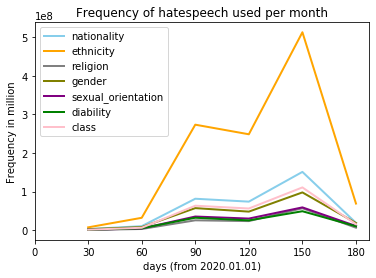

In [17]:
fig, ax = plt.subplots()
ax.plot( days_lst, 'is_about_nationality', data=freq_df, marker='', color='skyblue', linewidth=2, label="nationality")
ax.plot( days_lst, 'is_about_ethnicity', data=freq_df, marker='', color='orange', linewidth=2, label = "ethnicity")
ax.plot( days_lst, 'is_about_religion', data=freq_df, marker='', color='grey', linewidth=2, label="religion")
ax.plot( days_lst, 'is_about_gender', data=freq_df, marker='', color='olive', linewidth=2, label="gender")
ax.plot( days_lst, 'is_about_sexual_orientation', data=freq_df, marker='', color='purple', linewidth=2, label="sexual_orientation")
ax.plot( days_lst, 'is_about_disability', data=freq_df, marker='', color='green', linewidth=2, label="diability")
ax.plot( days_lst, 'is_about_class', data=freq_df, marker='', color='pink', linewidth=2, label="class")
ax.set(xlabel='days (from 2020.01.01)',
      ylabel='Frequency in million',
      title='Frequency of hatespeech used per month')

ax.xaxis.set(ticks=np.arange(0,210,30))

plt.legend()
plt.savefig('/h/ypark/tweet_covid/hatespeech/output/plots/freq_hate.png', dpi=250)
fig.show()



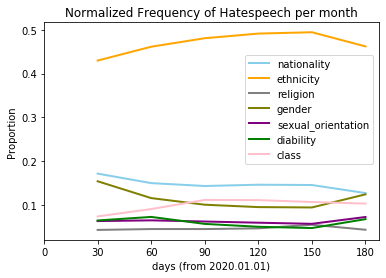

In [34]:
fig, ax = plt.subplots()
ax.plot( days_lst, 'is_about_nationality', data=normalized_freq_df, marker='', color='skyblue', linewidth=2, label="nationality")
ax.plot( days_lst, 'is_about_ethnicity', data=normalized_freq_df, marker='', color='orange', linewidth=2, label = "ethnicity")
ax.plot( days_lst, 'is_about_religion', data=normalized_freq_df, marker='', color='grey', linewidth=2, label="religion")
ax.plot( days_lst, 'is_about_gender', data=normalized_freq_df, marker='', color='olive', linewidth=2, label="gender")
ax.plot( days_lst, 'is_about_sexual_orientation', data=normalized_freq_df, marker='', color='purple', linewidth=2, label="sexual_orientation")
ax.plot( days_lst, 'is_about_disability', data=normalized_freq_df, marker='', color='green', linewidth=2, label="diability")
ax.plot( days_lst, 'is_about_class', data=normalized_freq_df, marker='', color='pink', linewidth=2, label="class")
ax.set(xlabel='days (from 2020.01.01)',
      ylabel='Proportion',
      title='Normalized Frequency of Hatespeech per month')

ax.xaxis.set(ticks=np.arange(0,210,30))
plt.legend(loc=(0.6, 0.35))
plt.savefig('/h/ypark/tweet_covid/hatespeech/output/plots/norm_freq_hate.png', dpi=250)

fig.show()

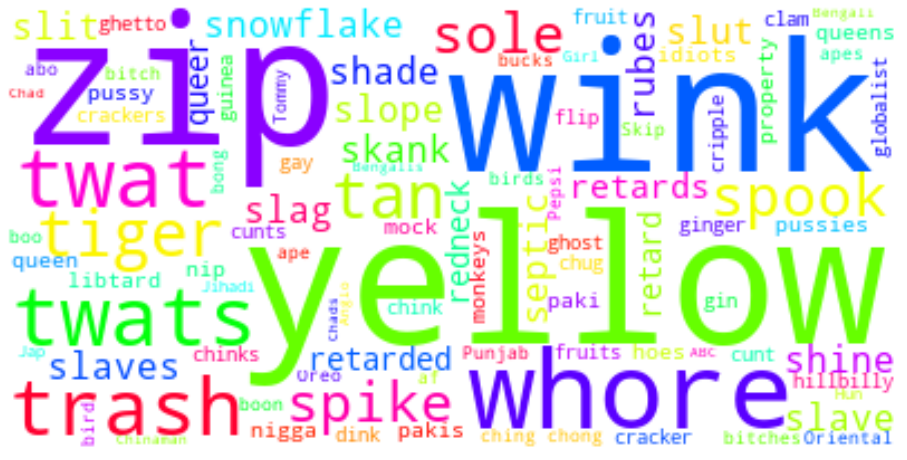

In [58]:
# dictionary=Counter(filtered_text)

cloud = WordCloud(max_font_size=80,colormap="hsv", background_color="white").generate_from_frequencies(freq_dict_30)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

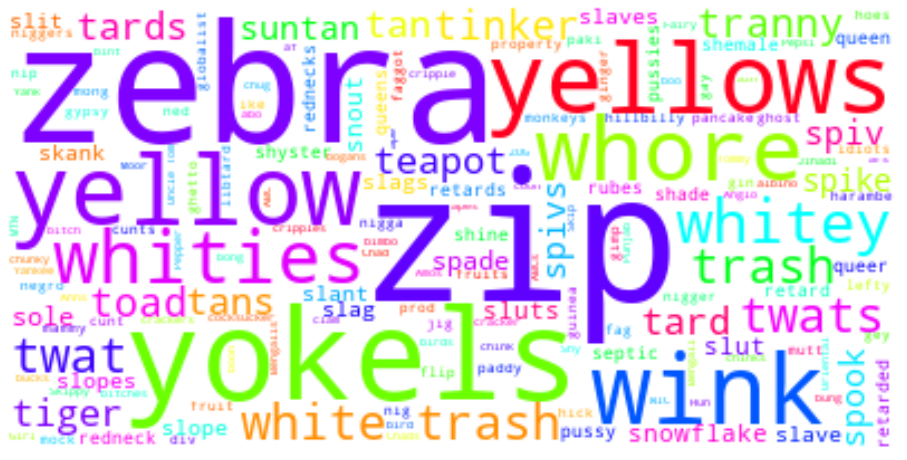

In [59]:
cloud = WordCloud(max_font_size=80,colormap="hsv", background_color="white").generate_from_frequencies(freq_dict_180)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
hate_freq_df_all = pd.DataFrame()
for days in hate_freq_df_dict.keys():
    hate_freq_df_all = hate_freq_df_all.append(hate_freq_df_dict[days])
hate_freq_df_group = hate_freq_df_all.groupby(by='term')
hate_freq_combines = hate_freq_df_group.sum(by='freq')

hate_freq_combines.sort_values(by='freq', ascending=False)
top_20_words = hate_freq_combines.sort_values(by='freq', ascending=False)[:20]
buttom_20_words = hate_freq_combines.sort_values(by='freq', ascending=False)[-20:]

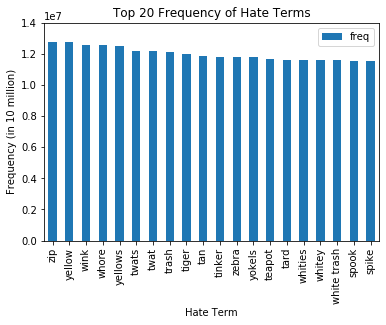

In [92]:
top_20_words.plot.bar(y='freq')
plt.xlabel("Hate Term")
plt.ylabel("Frequency (in 10 million)")
plt.title("Top 20 Frequency of Hate Terms")
plt.ylim(0, 14000000)
plt.show()

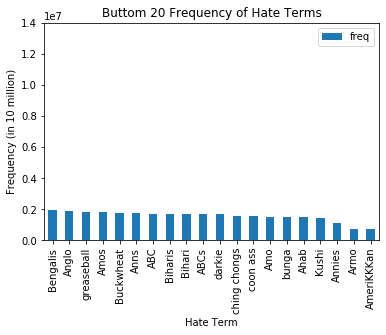

In [93]:

buttom_20_words.plot.bar(y='freq')
plt.xlabel("Hate Term")
plt.ylabel("Frequency (in 10 million)")
plt.title("Buttom 20 Frequency of Hate Terms")
plt.ylim(0, 14000000)
plt.show()